<a href="https://colab.research.google.com/github/divya2212001/colabs/blob/main/attention_simplified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Mechanism: A Simple Visual Guide

**Goal:** Understand how attention works in transformers through a simple example.

**What you'll learn:**
- What Query (Q), Key (K), and Value (V) mean
- How attention weights are computed
- How words incorporate context from other words

## The Core Idea

**Attention allows each word to "look at" other words in a sentence and decide which ones are most relevant.**

Think of it like a search engine:
- **Query (Q):** Your search question  
- **Key (K):** The index of each document  
- **Value (V):** The actual content

The formula: $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

In [9]:
# Setup
import torch
import torch.nn as nn
import torch.nn.functional as F  # Hint: Common alias used for torch.nn.functional

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Step 1: Create a Simple Sentence

In [10]:
sentence = "Mohan ate apple because it was healthy."

tokens = sentence.split()
# Hint: Split sentence into words using whitespace

vocab = {word: idx for idx, word in enumerate(tokens)}
# Hint: Built-in function that gives (index, value) pairs

token_indices = torch.tensor([vocab[token] for token in tokens])

# Hint: Convert Python list to PyTorch tensor

print(f"Sentence: {tokens}")
# Hint: Variable storing the full text

print(f"Tokens: {vocab}")
# Hint: List of individual words

print(f"Number of tokens: {token_indices}")
# Hint: Use built-in function to count elements in a list

Sentence: ['Mohan', 'ate', 'apple', 'because', 'it', 'was', 'healthy.']
Tokens: {'Mohan': 0, 'ate': 1, 'apple': 2, 'because': 3, 'it': 4, 'was': 5, 'healthy.': 6}
Number of tokens: tensor([0, 1, 2, 3, 4, 5, 6])


## Step 2: Create Embeddings

Each word gets a vector representation.

In [11]:
d_model = 8  # embedding dimension

embedding = nn.Embedding(len(vocab), d_model)
# Hint: Layer that converts token indices into dense vectors

embeddings = embedding(token_indices)

print(f"Embeddings shape: {embeddings.shape}")
# Hint: Tensor attribute that returns its dimensions as a tuple

print(f"Each token is now represented by {d_model} numbers")

Embeddings shape: torch.Size([7, 8])
Each token is now represented by 8 numbers


## Step 3: Create Q, K, V

We transform embeddings into Query, Key, and Value matrices.

In [12]:
# Linear transformations
W_Q = nn.Linear(d_model, d_model, bias=False)
W_K = nn.Linear(d_model, d_model, bias=False)
W_V = nn.Linear(d_model, d_model, bias=False)

Q = W_Q(embeddings)  # "What am I looking for?"
K = W_K(embeddings)  # "What do I contain?"
V = W_V(embeddings)  # "The actual information"

print(f"Q shape: {Q.shape}")
print(f"K shape: {K.shape}")
print(f"V shape: {V.shape}")

Q shape: torch.Size([7, 8])
K shape: torch.Size([7, 8])
V shape: torch.Size([7, 8])


## Step 4: Compute Attention Scores

Calculate how much each word should attend to every other word.

In [13]:
# Compute attention scores: Q × K^T
attention_scores = torch.matmul(Q, K.transpose(-2, -1))
# Hint: Use the PyTorch module (not NumPy) for matrix multiplication

print(f"Attention scores shape: {attention_scores.shape}")
# Hint: Variable that stores the result of Q × Kᵀ

print(f"This is a {len(tokens)}×{len(tokens)} matrix")

Attention scores shape: torch.Size([7, 7])
This is a 7×7 matrix


## Step 5: Scale and Apply Softmax

Scale by √d_k to prevent large values, then softmax to get probabilities.

In [23]:
help(F.softmax)

Help on function softmax in module torch.nn.functional:

softmax(input: torch.Tensor, dim: Optional[int] = None, _stacklevel: int = 3, dtype: Optional[int] = None) -> torch.Tensor
    Apply a softmax function.

    Softmax is defined as:

    :math:`\text{Softmax}(x_{i}) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}`

    It is applied to all slices along dim, and will re-scale them so that the elements
    lie in the range `[0, 1]` and sum to 1.

    See :class:`~torch.nn.Softmax` for more details.

    Args:
        input (Tensor): input
        dim (int): A dimension along which softmax will be computed.
        dtype (:class:`torch.dtype`, optional): the desired data type of returned tensor.
          If specified, the input tensor is casted to :attr:`dtype` before the operation
          is performed. This is useful for preventing data type overflows. Default: None.

    .. note::
        This function doesn't work directly with NLLLoss,
        which expects the Log to be computed between

In [17]:
# Scale
d_k = d_model
scaled_scores = attention_scores / np.sqrt(d_k)
# Hint: Square root function from NumPy (used in scaled dot-product attention)

# Softmax: convert to probabilities
attention_weights = F.softmax(scaled_scores, dim=-1)
# Hint: Function that converts scores into probabilities along last dimension

# Verify rows sum to 1
print(f"Attention weights shape: {attention_weights.shape}")
# Hint: Tensor attribute that returns dimensions

print(f"Row sums (all should be 1.0): {attention_weights.sum(dim=-1)}")
# Hint: Tensor containing the normalized attention probabilities

Attention weights shape: torch.Size([7, 7])
Row sums (all should be 1.0): tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


##  Visualize Attention Weights

**This is the key visualization!** It shows which words attend to which other words.

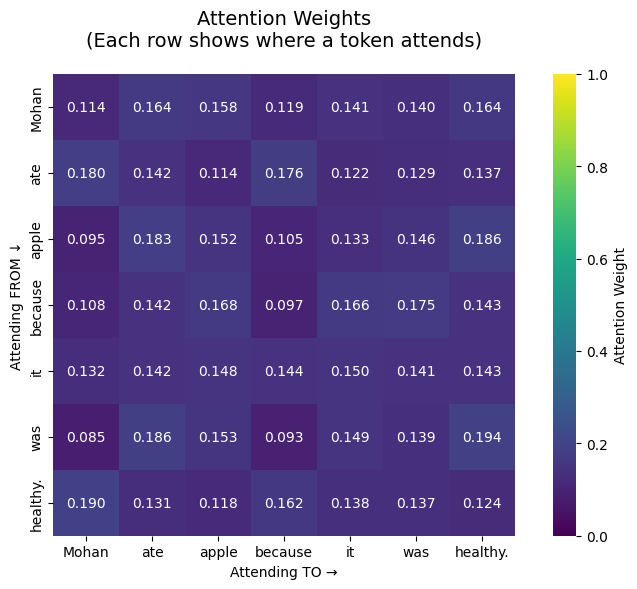


Interpretation:
  • Each row is a probability distribution (sums to 1)
  • Higher values = stronger attention
  • Look at 'chased' row: which words does it attend to?


In [18]:
plt.figure(figsize=(8, 6))
sns.heatmap(attention_weights.detach().numpy(),
            cmap='viridis',
            xticklabels=tokens,
            yticklabels=tokens,
            annot=True,
            fmt='.3f',
            square=True,
            vmin=0,
            vmax=1,
            cbar_kws={'label': 'Attention Weight'})
plt.title('Attention Weights\n(Each row shows where a token attends)', fontsize=14, pad=20)
plt.xlabel('Attending TO →')
plt.ylabel('Attending FROM ↓')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  • Each row is a probability distribution (sums to 1)")
print("  • Higher values = stronger attention")
print("  • Look at 'chased' row: which words does it attend to?")

## Step 6: Apply Attention to Values

Use attention weights to create contextualized representations.

In [19]:
# Weighted sum: Attention_weights × V
output = torch.matmul(attention_weights, V)

print(f"Output shape: {output.shape}")
print("\n Success! Each token now has a NEW representation")
print("  that incorporates information from other tokens")

Output shape: torch.Size([7, 8])

 Success! Each token now has a NEW representation
  that incorporates information from other tokens


## Before vs After

Compare original embeddings with contextualized embeddings.

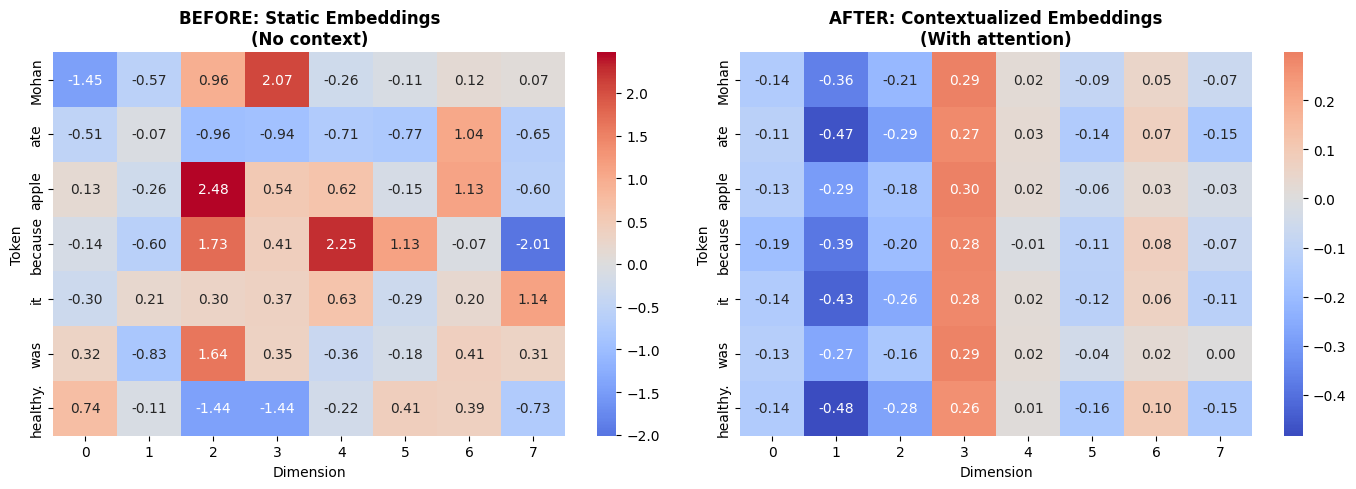

 The embeddings changed! Each word now contains information from other words.


In [20]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before
sns.heatmap(embeddings.detach().numpy(),
            cmap='coolwarm',
            center=0,
            yticklabels=tokens,
            annot=True,
            fmt='.2f',
            ax=axes[0])
axes[0].set_title('BEFORE: Static Embeddings\n(No context)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Dimension')
axes[0].set_ylabel('Token')

# After
sns.heatmap(output.detach().numpy(),
            cmap='coolwarm',
            center=0,
            yticklabels=tokens,
            annot=True,
            fmt='.2f',
            ax=axes[1])
axes[1].set_title('AFTER: Contextualized Embeddings\n(With attention)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Dimension')
axes[1].set_ylabel('Token')

plt.tight_layout()
plt.show()

print(" The embeddings changed! Each word now contains information from other words.")

In [21]:
#can you calculate distance between "Mohan" and "apple" in the output embeddings?
mohan_embedding = output[0]  # "Mohan" is the first token
apple_embedding = output[2]  # "apple" is the third token
cosine_similarity = F.cosine_similarity(mohan_embedding.unsqueeze(0), apple_embedding.unsqueeze(0))
print(f"Cosine similarity between 'Mohan' and 'apple': {cosine_similarity.item():.4f}")

#also calculate distance between "apple" and "it"
apple_embedding = output[2]  # "apple" is the third token
it_embedding = output[5]  # "it" is the sixth token
cosine_similarity_apple_it = F.cosine_similarity(apple_embedding.unsqueeze(0), it_embedding.unsqueeze(0))
print(f"Cosine similarity between 'apple' and 'it': {cosine_similarity_apple_it.item():.4f}")


Cosine similarity between 'Mohan' and 'apple': 0.9915
Cosine similarity between 'apple' and 'it': 0.9969


---

## Summary: What Just Happened?

1. **Created Q, K, V** from word embeddings via linear transformations
2. **Computed similarity** between all word pairs (Q × K^T)
3. **Scaled and normalized** with softmax → attention weights
4. **Applied weights to V** → contextualized representations

### Key Insight
**Self-attention allows each word to dynamically incorporate information from all other words in the sentence, creating context-aware representations.**

---

## Try This

Run the notebook with different sentences:
```python
sentence = "The dog barks loudly"
# Re-run all cells below
```

Observe how attention patterns change!

---

## The Complete Formula

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right) V$$

| Component | Meaning |
|-----------|---------|
| **QK^T** | Similarity scores between all token pairs |
| **÷√d_k** | Scale to prevent saturation |
| **softmax** | Convert to probabilities (rows sum to 1) |
| **× V** | Weighted average of values |

**Result:** Context-aware representations where each token incorporates information from relevant tokens.